### Данные для анализа/training:
- `Expression_cells.tsv.gz` - экспрессия очищенных типов нормальных клеток
- `Annotation_cells.tsv.gz` - аннотация
- `Expression_cell_lines.tsv.gz` - экспрессия линий злокачественных клеток различных типов опухолей
- `Annotation_cell_lines.tsv.gz` - аннотация

### Данные для тестирования: - экспрессии 2 образцов крови здоровых пациентов в
- `Normal-blood-expr.tsv` экспрессии 2 образцов крови здоровых пациентов
- `LUAD-expr.tsv` - 6 образцов аденокарциномы
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import logging
from implicit.als import AlternatingLeastSquares

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

In [2]:
data_path = '/home/iuliiasolomennikova/bostone_gene/'

In [3]:
cancer_sample_annot = pd.read_csv(data_path+'Annotation_cell_lines.tsv', sep='\t', index_col=0)
cancer_expr = pd.read_csv(data_path+'Expression_cell_lines.tsv', sep='\t', index_col=0)

cells_sample_annot = pd.read_csv(data_path+'Annotation_cells.tsv', sep='\t', index_col=0)
cells_expr = pd.read_csv(data_path+'Expression_cells.tsv', sep='\t', index_col=0)

# Аннотация

In [4]:
cancer_sample_annot = cancer_sample_annot.drop(cancer_sample_annot.columns[-2:], axis=1)
cancer_sample_annot = cancer_sample_annot.rename(columns={'dataset_h': 'Dataset', 'srr_h': 'Sample'})
cancer_sample_annot.set_index('Sample', drop=False, inplace=True)
cancer_sample_annot = cancer_sample_annot.rename_axis(None, axis='index')
cancer_sample_annot.drop(columns=['Sample', 'Dataset'], inplace=True)
cancer_sample_annot = cancer_sample_annot.rename(columns={'tumor_type': 'Cell_type'})
cancer_sample_annot.head(2)

,Cell_type
srr_cell_0,BRCA
srr_cell_1,BRCA


In [5]:
cells_sample_annot = cells_sample_annot.drop(cells_sample_annot.columns[-1:], axis=1)
cells_sample_annot = cells_sample_annot.rename(columns={'dataset_h': 'Dataset', 'general_cell_type': 'Cell_type', 'srr_h': 'Sample'})
cells_sample_annot.set_index('Sample', drop=False, inplace=True)

cells_sample_annot = cells_sample_annot.rename_axis(None, axis='index')
cells_sample_annot = cells_sample_annot.drop('Sample', axis=1)
cells_sample_annot = cells_sample_annot.drop('Dataset', axis=1)
cells_sample_annot.sample(3)

,Cell_type
srr_224,B_cells
srr_466,Macrophages
srr_183,Fibroblasts


In [6]:
merged_annot = pd.concat([cells_sample_annot, cancer_sample_annot])
merged_annot.sample(3)

,Cell_type
srr_142,Fibroblasts
srr_947,B_cells
srr_913,Macrophages


# Экспресии

In [7]:
# Transpose to have Gene as rows ans set name of index
cancer_expr = cancer_expr.T
cancer_expr.rename_axis('Gene',  axis='index', inplace=True)
cancer_expr.head(3)

,srr_cell_0,srr_cell_1,srr_cell_2,srr_cell_3,srr_cell_4,srr_cell_5,srr_cell_6,srr_cell_7,srr_cell_8,srr_cell_9,...,srr_cell_224,srr_cell_225,srr_cell_226,srr_cell_227,srr_cell_228,srr_cell_229,srr_cell_230,srr_cell_231,srr_cell_232,srr_cell_233
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.173913,0.000000,0.000000,0.000000,0.000000,0.093179,0.000000,0.0,...,0.000000,0.274133,0.250994,0.000000,0.227035,0.000000,0.272656,0.000000,0.000000,0.000000
A1CF,0.011732,0.048501,0.023425,0.043713,0.080633,0.005887,0.057628,0.049083,0.050671,0.0,...,0.038077,1.276720,0.963579,1.601615,0.761388,0.634379,0.346115,1.309550,0.369429,0.706884
A2M,0.011290,0.013744,0.066401,0.010893,0.020923,0.000000,0.112177,0.000000,0.038031,0.0,...,158.796192,0.017695,0.010769,0.028417,0.000000,0.000000,0.029175,0.173991,0.061940,0.000000


In [8]:
cells_expr = cells_expr.T
cells_expr.columns.name = None
cells_expr.rename_axis("Gene", axis='index', inplace=True)
cells_expr.head(3)

,srr_0,srr_1,srr_2,srr_3,srr_4,srr_5,srr_6,srr_7,srr_8,srr_9,...,srr_978,srr_979,srr_980,srr_981,srr_982,srr_983,srr_984,srr_985,srr_986,srr_987
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283250,0.000000,0.000000,...,0.334078,0.111991,0.000000,0.000000,0.057560,0.000000,0.003237,0.000000,0.000000,0.000000
A1CF,0.105129,0.065913,0.015755,0.037395,0.043908,0.064590,0.073207,0.144928,0.045884,0.012845,...,0.253289,0.008913,0.052548,0.107934,0.014586,0.000000,0.010081,0.014032,0.019239,0.010500
A2M,0.000000,0.000000,0.000000,0.120822,0.000000,0.061918,0.000000,0.000000,0.029344,0.000000,...,0.103331,1.270282,0.933142,0.130263,0.000000,578.288921,193.218463,0.000000,260.470247,360.399656


In [9]:
expr_feat = cancer_expr.join(cells_expr)
expr_feat = expr_feat.T
expr_feat.sample(3)

Gene,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
srr_cell_55,0.0,0.021708,3.627926,0.054461,0.703912,1.213204,0.000000,35.807785,16.512016,0.026915,...,47.370188,0.999062,2.931984,12.412860,1.774361,11.150072,353.196253,11.524665,28.061002,17.282527
srr_183,0.0,0.000000,37.527798,0.081075,0.036504,78.276395,0.019134,15.717162,18.297235,0.289220,...,8.232493,2.337785,4.747125,7.184041,0.101647,23.292841,499.608438,11.260832,22.495221,46.632541
srr_472,0.0,0.385800,8.441168,0.649887,0.000000,0.000000,0.000000,30.133460,0.000000,0.000000,...,9.355320,2.693616,11.759457,15.711584,1.160802,7.726941,248.921669,40.325012,23.493474,1.612374


In [10]:
annot_feat = merged_annot
annot_feat.sample(3)

,Cell_type
srr_892,Macrophages
srr_580,Macrophages
srr_114,Fibroblasts


# **Latent Dirichlet Allocation (LDA)**

Papers:
1. [Identifying gene expression programs of cell-type identity and cellular activity with single-cell RNA-Seq](https://elifesciences.org/articles/43803)

2. [Post-modified non-negative matrix factorization for deconvoluting the gene expression profiles of specific cell types from heterogeneous clinical samples based on RNA-sequencing data](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/pdf/10.1002/cem.2929?casa_token=gf9lOZ_Fx2AAAAAA:mH44_dQVdxpM0PFdBtTonIo5geaSf6LAOe-2cxIG7iM2xEXDx0woQhnM2puhIZ_73W9nNGhw4Y5BYpY)

Метод **LDA** используется для анализа тематической структуры коллекции текстов. В контексте анализа клеточных данных, авторы применили модифицированную версию LDA для деконволюции и определения пропорций различных типов клеток на основе данных об экспрессии генов. Метод был предложен для использования в условиях, когда
экспрессии различных типов клеток или сигнатурных генов неизвестны.

Авторы обнаружили, что методы, такие как ICA (Independent Component Analysis), LDA и NMF (Non-Negative Matrix Factorization), но не PCA (Principal Component Analysis), могут точно обнаруживать как активность, так и идентичность генетической экспрессии (GEP). Однако из-за стохастической природы этих алгоритмов, они могут давать различные результаты при многократном повторении, что затрудняет их интерпретацию.

Этот подход был сначала проверен экспериментально с использованием синтетических смесей чистых типов тканей и смоделированных смесей с хорошо продуманными пропорциями. Результаты показали, что
деконволированные паттерны экспрессии генов хорошо согласуются с экспериментальными (r > 0,99). 

-----------------------------------
-----------------------------------
-----------------------------------
Таким образом, **LDA** - это генеративная вероятностная модель, и предполагается, что каждый документ (в данном случае, `образец`) можно рассматривать как смесь различных "тем" (`типов клеток`) с определенными пропорциями. Каждая тема представляет собой `распределение вероятностей` на множестве генов. Аналогично, каждый ген может быть связан с различными темами с определенными вероятностями. В нашем  жеслучае можно рассматривать `каждый тип клеток как тему`, а значения `экспрессии генов - как входные признаки`.

Далее - обучаем LDA на векторизованные данные экспрессии генов -> модель оценит пропорции тем для каждого образца.




**Переменные и параметры LDA:**

$K$ - общее количество тем (типов клеток)

$N$ - общее количество генов

$M$ - общее количество образцов (документов)

$W$ - матрица экспрессии генов размерности $M \times N$, где каждый элемент $w_{ij}$ представляет экспрессию гена $j$ в образце $i$

$Z$ - матрица скрытых переменных размерности $M \times K$, где каждый элемент $z_{ik}$ представляет пропорцию темы $k$ в образце $i$

$\Theta$ - матрица параметров распределения тем в образцах размерности $M \times K$, где каждый элемент $\theta_{ik}$ представляет вероятность темы $k$ в образце $i$

$\Phi$ - матрица параметров распределения генов в темах размерности $K \times N$, где каждый элемент $\phi_{kj}$ представляет вероятность гена $j$ в теме $k$

Цель - оценить значения матриц $\Theta$ и $\Phi$ на основе данных $W$ (данных об экспрессии генов для каждого образца и их аннотации) . Для этого применяется алгоритм EM (Expectation-Maximization), который позволяет итеративно оценивать эти параметры, улучшая соответствие модели к данным 

**Вот шаги алгоритма:**

1. Инициализация: Начнем с инициализации матриц $\Theta$ и $\Phi$ случайными значениями.

2. E-шаг (Expectation): В этом шаге оцениваются скрытые переменные $Z$ (пропорции тем в каждом образце) на основе текущих значений $\Theta$ и $\Phi$. Вычисляется ожидание скрытых переменных $Z$ при условии данных и текущих параметров.

3. M-шаг (Maximization): В этом шаге обновляются параметры $\Theta$ и $\Phi$ на основе ожиданий скрытых переменных, полученных на предыдущем шаге. Это делается с использованием метода максимального правдоподобия.

4. Повторение E-шага и M-шага: Шаги E и M повторяются до сходимости алгоритма, то есть до достижения заданного критерия останова. Т.е. после завершения алгоритма, матрица $\Theta$ будет содержать оценки пропорций типов клеток в каждом образце, а матрица $\Phi$ - оценки вероятностей генов для каждой темы.













И последний шаг - извлечение пропорций типов клеток: после обучения LDA-модели можно извлечь пропорции типов клеток для каждого образца. Эти пропорции представляют собой вклад каждого типа клеток в общий профиль экспрессии генов образца (т.е. просто оценку вероятностей распределения типов клеток в каждом образце и распределения генов для каждого типа клеток. Эти распределения позволяют определить пропорции типов клеток в каждом образце на основе их профиля экспрессии генов).




---------------------------------------
---------------------------------------
---------------------------------------

В контексте анализа типов клеток LDA может быть использована для обнаружения скрытой структуры типов клеток в данных экспрессии генов. Представляя типы клеток как темы, а значения экспрессии генов как слова, LDA может оценить пропорции типов клеток для каждого образца на основе наблюдаемых паттернов экспрессии генов.

LDA предполагает, что каждый документ (образец) представляет собой смесь тем (типов клеток), а наблюдаемые значения экспрессии генов формируются на основе этих пропорций тем. Обучив модель LDA на данных экспрессии генов, можно выявить пропорции скрытых типов клеток для каждого образца. Эти пропорции обеспечивают количественную меру относительного присутствия различных типов клеток в образцах.

Процесс LDA включает в себя оценку вероятностей распределения тем для каждой клетки и распределения генов для каждой темы. Эти вероятности могут быть использованы для определения пропорций типов клеток, основанных на их экспрессии генов. Таким образом, LDA может помочь выявить скрытую структуру в данных и идентифицировать типы клеток на основе их профиля экспрессии генов. То есть мы проводим моделирование "тем" и их распределений внутри каждого образца.



In [11]:
# convert cell_types to numerical values
cell_types=annot_feat['Cell_type'].unique()
cell_type_mapping = {cell_type: i for i, cell_type in enumerate(cell_types)}
annot_feat_numeric = annot_feat.copy()
annot_feat_numeric['Cell_type'] = annot_feat_numeric['Cell_type'].map(cell_type_mapping)
annot_feat_numeric.sample(3)

,Cell_type
srr_345,5
srr_482,7
srr_924,3


In [32]:
merged_data = pd.merge(expr_feat, annot_feat_numeric, left_index=True, right_index=True)
merged_data.sample(3)

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk,Cell_type
srr_361,0.353887,0.063856,71.254992,0.146772,0.396788,22.532958,0.260911,21.009701,17.871098,0.0,...,2.738649,6.928438,15.118364,0.465450,15.487177,281.810707,10.982320,31.134432,40.306353,6
srr_31,0.000000,0.055851,0.000000,0.647828,0.179649,0.000000,0.000000,15.530150,5.795269,0.0,...,8.819315,23.673281,26.783447,0.516682,12.059372,143.061709,37.237826,24.529550,0.627875,1
srr_972,0.000000,0.037880,0.000000,0.028633,0.000000,0.000000,0.000000,50.675200,22.845382,0.0,...,1.579886,3.569746,15.286533,0.155272,3.563948,220.934549,20.905289,17.583170,18.964571,2


In [47]:
from sklearn.decomposition import LatentDirichletAllocation

In [35]:
sample_ids = merged_data.index.values
gene_ids = merged_data.columns[:-1].values
expression_matrix = merged_data.iloc[:, :-1].values
cell_type_labels = merged_data.iloc[:, -1].values

lda = LatentDirichletAllocation(n_components=len(annot_feat['Cell_type'].unique()))
lda.fit(expression_matrix)

# Get the cell type proportions for each sample
sample_proportions = lda.transform(expression_matrix)

result_df = pd.DataFrame(sample_proportions, index=sample_ids, columns=annot_feat['Cell_type'].unique())

In [36]:
result_df

,B_cells,CD4_T_cells,CD8_T_cells,Monocytes,Neutrophils,NK_cells,Fibroblasts,Macrophages,Endothelium,T_cells,BRCA,LUAD,PAAD,SKCM,OVCA,DLBCL,Undefined,NSCLC
srr_cell_0,0.045070,5.555551e-08,2.576182e-01,5.555551e-08,5.555551e-08,5.555551e-08,5.555551e-08,1.116768e-06,5.255072e-01,0.000405,1.014697e-02,2.233592e-02,5.555551e-08,5.555551e-08,5.555551e-08,0.137747,1.168275e-03,5.555551e-08
srr_cell_1,0.033593,5.555551e-08,1.275660e-01,5.555551e-08,5.555551e-08,4.428860e-06,5.555551e-08,5.213519e-05,6.249448e-01,0.023461,3.746486e-03,5.555551e-08,5.555551e-08,5.555551e-08,5.555551e-08,0.183703,2.927967e-03,5.555551e-08
srr_cell_2,0.036416,5.364260e-06,2.532326e-01,9.164838e-05,1.547710e-04,5.555551e-08,1.138111e-06,2.906261e-01,4.994254e-02,0.004625,4.206708e-06,5.555551e-08,2.781530e-03,5.555551e-08,5.555551e-08,0.360736,1.383319e-03,5.555551e-08
srr_cell_3,0.036919,5.555551e-08,2.487929e-01,5.555551e-08,5.555551e-08,5.555551e-08,5.555551e-08,2.907971e-01,5.977256e-02,0.043354,8.422921e-06,5.555551e-08,1.055048e-06,5.555551e-08,5.555551e-08,0.316597,3.757865e-03,5.555551e-08
srr_cell_4,0.045874,5.555551e-08,2.863058e-01,5.555551e-08,5.555551e-08,5.555551e-08,5.555551e-08,5.555551e-08,4.851019e-01,0.000127,5.754769e-03,1.929639e-02,5.555551e-08,5.555551e-08,5.555551e-08,0.157262,2.768414e-04,5.555551e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
srr_983,0.113000,5.555551e-08,5.555551e-08,1.877424e-01,3.666433e-01,5.555553e-08,5.555553e-08,5.555551e-08,5.555551e-08,0.000897,5.555551e-08,5.555551e-08,5.555551e-08,2.850744e-01,4.663327e-02,0.000010,5.575041e-08,5.555551e-08
srr_984,0.239755,5.555551e-08,2.720001e-05,1.844084e-01,2.452665e-01,5.555551e-08,5.555551e-08,1.976060e-06,5.555551e-08,0.006325,5.555551e-08,5.555551e-08,5.555551e-08,2.199260e-01,1.039484e-01,0.000084,5.555551e-08,2.561398e-04
srr_985,0.031560,3.150785e-01,2.123107e-03,5.555551e-08,5.007354e-05,5.555551e-08,5.555551e-08,1.617694e-02,8.096187e-05,0.587344,1.979635e-03,5.555551e-08,5.555551e-08,5.555551e-08,5.555551e-08,0.002787,4.281978e-02,5.555551e-08
srr_986,0.192433,5.555551e-08,1.483904e-07,1.933416e-01,2.551451e-01,5.555551e-08,5.555551e-08,5.555551e-08,5.555551e-08,0.001656,5.555552e-08,5.555551e-08,3.472528e-06,2.488784e-01,1.085139e-01,0.000028,5.555551e-08,5.555551e-08


# Model:

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

feature = expr_feat.iloc[:, :-1]
target=result_df.iloc[:, :]

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

In [42]:
y_test_pred_df = pd.DataFrame(y_test_pred, index=y_test.index, columns=y_test.columns)
y_test_pred_df.sample(5)

,B_cells,CD4_T_cells,CD8_T_cells,Monocytes,Neutrophils,NK_cells,Fibroblasts,Macrophages,Endothelium,T_cells,BRCA,LUAD,PAAD,SKCM,OVCA,DLBCL,Undefined,NSCLC
srr_cell_220,0.000000,0.000000,0.108980,0.015749,0.000000,0.000000,0.047089,0.013487,0.015965,0.064544,0.019751,0.000000,0.051592,0.008327,0.000000,0.748337,0.000000,0.012820
srr_227,0.030967,0.000000,0.000000,0.000000,0.004435,0.006284,0.005854,0.001944,0.010126,0.000000,0.000000,0.000000,0.000000,0.004150,0.001976,0.008898,0.006898,0.974027
srr_55,0.000000,0.024814,0.236201,0.000336,0.028907,0.005039,0.014395,0.000000,0.000000,0.011448,0.000000,0.089057,0.035874,0.000000,0.592439,0.000000,0.000000,0.000000
srr_309,0.325467,0.002952,0.000000,0.103727,0.053713,0.018689,0.000000,0.021389,0.000000,0.000000,0.011309,0.004164,0.002059,0.428687,0.043324,0.000000,0.006189,0.000297
srr_285,0.163720,0.060217,0.000000,0.013122,0.000000,0.000000,0.000000,0.020030,0.000000,0.577669,0.167082,0.000000,0.000000,0.000000,0.002785,0.005075,0.016380,0.001529


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_test_pred_df)
mae = mean_absolute_error(y_test, y_test_pred_df)
r2 = r2_score(y_test, y_test_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

Mean Squared Error: 0.0002805837125482878
Mean Absolute Error: 0.008278689891703585
R2 Score: 0.9812125488444686


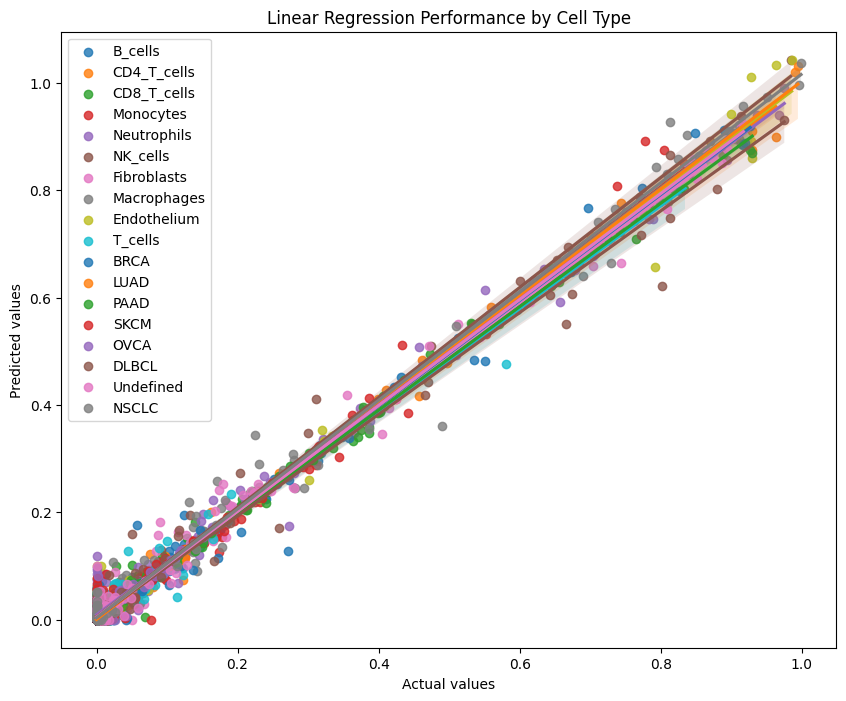

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))

for col in target.columns:
    sns.regplot(x=y_test[col], y=y_test_pred_df[col], ax=ax, label=col)

ax.set_xlabel('Actual values')
ax.set_ylabel('Predicted values')
ax.set_title('Linear Regression Performance by Cell Type')
ax.legend()
plt.show()


# Тестирование:

In [51]:
LUAD = pd.read_csv(data_path + 'LUAD-expr.tsv', sep='\t', index_col=0) 
NORMAL = pd.read_csv(data_path + 'Normal-blood-expr.tsv', sep='\t', index_col=0)

LUAD=LUAD.T
NORMAL=NORMAL.T

### Раковые:

In [60]:
common_columns = list(set(LUAD.columns).intersection(X_train.columns))
LUAD_common = LUAD[common_columns]

LUAD_common_ordered = LUAD_common[X_train.columns]

LUAD_predictions = model.predict(LUAD_common_ordered)

In [71]:
LUAD_predictions_df = pd.DataFrame(LUAD_predictions, columns=y_train.columns, index=LUAD.index)
LUAD_predictions_df

,B_cells,CD4_T_cells,CD8_T_cells,Monocytes,Neutrophils,NK_cells,Fibroblasts,Macrophages,Endothelium,T_cells,BRCA,LUAD,PAAD,SKCM,OVCA,DLBCL,Undefined,NSCLC
VIC-020-CL,0.000000,0.084465,0.000000,0.009124,0.092665,0.001315,0.00000,0.048681,0.142129,0.105723,0.000000,0.018513,0.085770,0.000000,0.104675,0.000000,0.119366,0.368129
VIC-025-CL,0.003990,0.000000,0.077320,0.019922,0.059910,0.035812,0.00000,0.042971,0.228750,0.028063,0.040813,0.058589,0.157841,0.000000,0.118859,0.018252,0.145355,0.007110
VIC-026-CL,0.000000,0.132711,0.000000,0.000000,0.277603,0.000000,0.01826,0.000000,0.000000,0.092194,0.130699,0.017026,0.051077,0.079436,0.000000,0.054063,0.000000,1.087694
VIC-031-CL,0.000000,0.071006,0.000000,0.065488,0.131884,0.047797,0.00000,0.000000,0.055400,0.160803,0.000000,0.029241,0.000000,0.000000,0.065457,0.101679,0.000000,1.013192
VIC-033-CL,0.061199,0.046089,0.000000,0.000000,0.028794,0.000000,0.00000,0.095286,0.616446,0.005289,0.035257,0.000000,0.041535,0.008577,0.102133,0.068624,0.034897,0.014411
VIC-034-CL,0.000000,0.000000,0.069532,0.000000,0.056457,0.001811,0.00000,0.055975,0.090846,0.018343,0.006697,0.007953,0.570747,0.091776,0.091221,0.018700,0.051094,0.034269


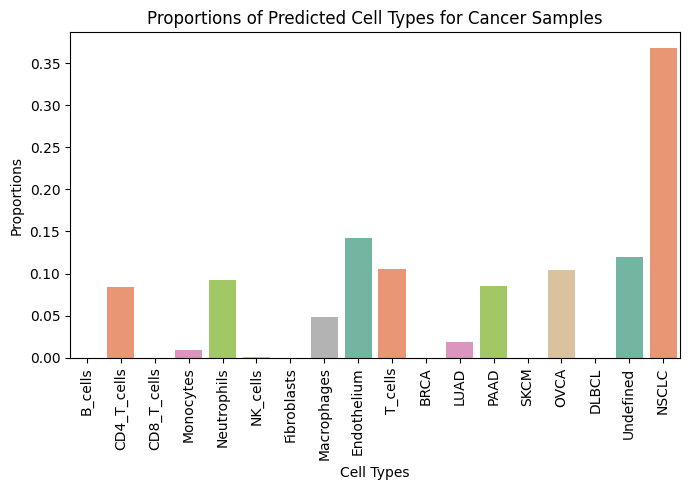

In [96]:
cell_types = LUAD_predictions_df.columns
proportions = LUAD_predictions_df.iloc[0].values

plt.figure(figsize=(7, 5))
colors = sns.color_palette("Set2")

sns.barplot(x=cell_types, y=proportions, palette=colors)

plt.xlabel('Cell Types')
plt.ylabel('Proportions')
plt.title('Proportions of Predicted Cell Types for Cancer Samples')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Здоровые:

In [91]:
common_columns = list(set(NORMAL.columns).intersection(X_train.columns))
NORMAL_common = NORMAL[common_columns]

NORMAL_common_ordered = NORMAL_common[X_train.columns]

NORMAL_predictions = model.predict(NORMAL_common_ordered)


In [92]:
NORMAL_predictions.shape

(2, 18)

In [93]:
NORMAL_predictions_df = pd.DataFrame(NORMAL_predictions, columns=y_train.columns, index=NORMAL.index)
NORMAL_predictions_df

,B_cells,CD4_T_cells,CD8_T_cells,Monocytes,Neutrophils,NK_cells,Fibroblasts,Macrophages,Endothelium,T_cells,BRCA,LUAD,PAAD,SKCM,OVCA,DLBCL,Undefined,NSCLC
SampleA,0.029737,0.143895,0.053424,0.051315,-0.006299,0.014613,0.003686,0.012363,0.045508,0.062136,-0.012796,0.040140,-0.002036,-0.007929,0.185227,0.026959,0.354953,0.005175
SampleB,0.020649,0.101583,0.061828,0.038937,0.010396,0.021584,-0.005592,0.025256,0.068063,0.079665,-0.003055,0.049913,0.009799,-0.011913,0.162224,0.026715,0.336680,0.007332


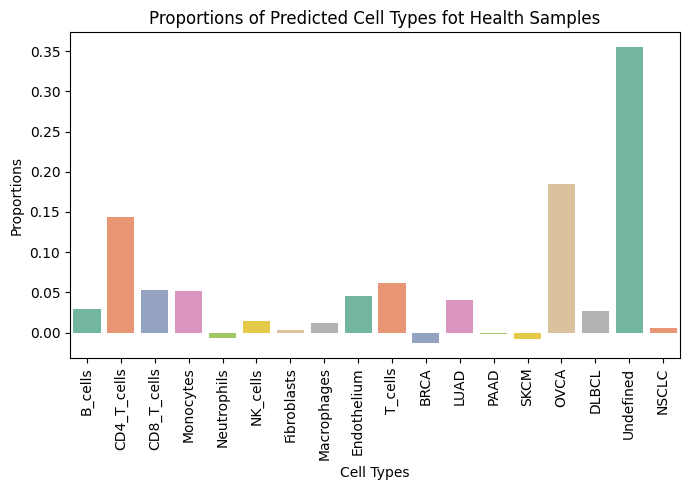

In [95]:
cell_types = NORMAL_predictions_df.columns
proportions = NORMAL_predictions_df.iloc[0].values

plt.figure(figsize=(7, 5))
colors = sns.color_palette("Set2")

sns.barplot(x=cell_types, y=proportions, palette=colors)

plt.xlabel('Cell Types')
plt.ylabel('Proportions')
plt.title('Proportions of Predicted Cell Types fot Health Samples')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()